Mount drive to work from Google drive and Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install Spark and instantiate the environment variable into the Colab host

In [ ]:
#######################################
###!@0 START INIT ENVIRONMENT
!ls /content/drive/MyDrive/DE_Scale_Project/SparkData/spark-3.5.2-bin-hadoop3.tgz
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/MyDrive/DE_Scale_Project/SparkData/spark-3.5.2-bin-hadoop3.tgz
!pip install -q findspark
!pip install -q pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.2-bin-hadoop3"
###!@0 END INIT ENVIRONMENT

/content/drive/MyDrive/DE_Scale_Project/SparkData/spark-3.5.2-bin-hadoop3.tgz
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 12.4 MB/s eta 0:00:00


Create symbolic links to the area where the datasets are present to work with

In [ ]:
!mkdir -p /content/data
!rm -rf /content/data/*.csv
!ln -s /content/drive/MyDrive/DE_Scale_Project/Datasets/All_cities/*.csv /content/data/

Spark initiatlisation

In [ ]:
#######################################
###!@1 START OF PYSPARK INIT
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
input_type = 'sample'
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
# Spark is ready to go within Colab!
###!@1 END OF PYSPARK INIT

Read the dataset, i.e. ALL cities Pollutant data csv file

In [ ]:
def read_csv(path_to_file):
  return spark.read.option("delimiter", ",").csv(path_to_file, header=True, inferSchema=True)

# df_Delhi = read_csv('/content/data/City_Mumbai_wise_raw_data_1Hr_2019_2023.csv')
# df_Bengaluru = read_csv('/content/data/City_Bengaluru_wise_raw_data_1Hr_2019_2023.csv')
# df_Hyderabad = read_csv('/content/data/City_Hyderabad_wise_raw_data_1Hr_2019_2023.csv')
# df_Chennai = read_csv('/content/data/City_Chennai_wise_raw_data_1Hr_2019_2023.csv')
# df_Kolkata = read_csv('/content/data/City_Kolkata_wise_raw_data_1Hr_2019_2023.csv')
# df_Mumbai = read_csv('/content/data/City_Mumbai_wise_raw_data_1Hr_2019_2023.csv')
df_All_cities = read_csv('/content/data/City_All_wise_raw_data_1Hr_2019_2023.csv')

Import Spark related functions and methods

In [ ]:
# prompt: import all spark related libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

In [ ]:
df_All_cities.printSchema()

root
 |-- City: string (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- PM2.5 (µg/m³): double (nullable = true)
 |-- PM10 (µg/m³): double (nullable = true)
 |-- NO (µg/m³): double (nullable = true)
 |-- NO2 (µg/m³): double (nullable = true)
 |-- NOx (ppb): double (nullable = true)
 |-- NH3 (µg/m³): double (nullable = true)
 |-- SO2 (µg/m³): double (nullable = true)
 |-- CO (mg/m³): double (nullable = true)
 |-- Ozone (µg/m³): double (nullable = true)
 |-- Benzene (µg/m³): double (nullable = true)
 |-- Toluene (µg/m³): double (nullable = true)
 |-- Xylene (µg/m³): double (nullable = true)
 |-- O Xylene (µg/m³): double (nullable = true)
 |-- Eth-Benzene (µg/m³): double (nullable = true)
 |-- MP-Xylene (µg/m³): double (nullable = true)
 |-- AT (°C): double (nullable = true)
 |-- RH (%): double (nullable = true)
 |-- WS (m/s): double (nullable = true)
 |-- WD (deg): double (nullable = true)
 |-- RF (mm): double (nullable = true)
 |-- TOT-RF (mm): double (nullable = true)
 |-

1. Change the names of columns to make it easy to work in Spark enviroment.
2. Convert timestamp from string to timestamp format for later computations.
3. Then order the dataset by Cities and within each city by timestamp.

In [ ]:
df_All_cities = df_All_cities.withColumnRenamed("PM2.5 (µg/m³)", "PM2p5")
df_All_cities = df_All_cities.withColumnRenamed("PM10 (µg/m³)", "PM10")
df_All_cities = df_All_cities.withColumnRenamed("NO (µg/m³)", "NO")
df_All_cities = df_All_cities.withColumnRenamed("NO2 (µg/m³)", "NO2")
df_All_cities = df_All_cities.withColumnRenamed("NOx (ppb)", "NOx")
df_All_cities = df_All_cities.withColumnRenamed("NH3 (µg/m³)", "NH3")
df_All_cities = df_All_cities.withColumnRenamed("CO (mg/m³)", "CO")
df_All_cities = df_All_cities.withColumnRenamed("SO2 (µg/m³)", "SO2")
df_All_cities = df_All_cities.withColumnRenamed("Ozone (µg/m³)", "Ozone")
df_All_cities = df_All_cities.withColumnRenamed("Benzene (µg/m³)", "Benzene")
df_All_cities = df_All_cities.withColumnRenamed("Toluene (µg/m³)", "Toluene")
df_All_cities = df_All_cities.withColumnRenamed("Xylene (µg/m³)", "Xylene")
df_All_cities = df_All_cities.withColumnRenamed("O Xylene (µg/m³)", "O-Xylene")
df_All_cities = df_All_cities.withColumnRenamed("Eth-Benzene (µg/m³)", "Eth-Benzene")
df_All_cities = df_All_cities.withColumnRenamed("MP-Xylene (µg/m³)" , "MP-Xylene")
df_All_cities = df_All_cities.withColumnRenamed("AT (°C)", "Temperature")
df_All_cities = df_All_cities.withColumnRenamed("RH (%)", "Humidity")
df_All_cities = df_All_cities.withColumnRenamed("WS (m/s)", "Wind_Speed")
df_All_cities = df_All_cities.withColumnRenamed("WD (deg)", "Wind_Direction")
df_All_cities = df_All_cities.withColumnRenamed("RF (mm)", "RF")
df_All_cities = df_All_cities.withColumnRenamed("TOT-RF (mm)", "TOT-RF")
df_All_cities = df_All_cities.withColumnRenamed("SR (W/mt2)", "SR")
df_All_cities = df_All_cities.withColumnRenamed("BP (mmHg)", "BP")
df_All_cities = df_All_cities.withColumnRenamed("VWS (m/s)", "VWS" )
df_All_cities = df_All_cities.withColumn("Timestamp", to_timestamp(col("Timestamp"), "M/d/yyyy H:mm"))
df_All_cities = df_All_cities.orderBy(col("city"), col("timestamp"))

In [ ]:
# print schema and see the inital records of the dataframe
df_All_cities.printSchema()
df_All_cities.show(5)

root
 |-- City: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- PM2p5: double (nullable = true)
 |-- PM10: double (nullable = true)
 |-- NO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- NOx: double (nullable = true)
 |-- NH3: double (nullable = true)
 |-- SO2: double (nullable = true)
 |-- CO: double (nullable = true)
 |-- Ozone: double (nullable = true)
 |-- Benzene: double (nullable = true)
 |-- Toluene: double (nullable = true)
 |-- Xylene: double (nullable = true)
 |-- O-Xylene: double (nullable = true)
 |-- Eth-Benzene: double (nullable = true)
 |-- MP-Xylene: double (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Wind_Speed: double (nullable = true)
 |-- Wind_Direction: double (nullable = true)
 |-- RF: double (nullable = true)
 |-- TOT-RF: double (nullable = true)
 |-- SR: double (nullable = true)
 |-- BP: double (nullable = true)
 |-- VWS: double (nullable = true)

+---------

Calculate the percentage of missing values in each columns of the dataframe.

In [ ]:
total_rows = df_All_cities.count()
missing_percentage_df = df_All_cities.select([(sum(when(col(c).isNull(), 1).otherwise(0)) / total_rows * 100).alias(c) for c in df_All_cities.columns])
missing_percentage_df.show()

+----+---------+-------------------+-----------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-----------------+-----------------+----------------+------------------+-----------------+-----------------+--------------------+-------------------+--------------------+------------------+------+------------------+------------------+----------------+
|City|Timestamp|              PM2p5|             PM10|                 NO|               NO2|                NOx|               NH3|                SO2|                 CO|              Ozone|            Benzene|          Toluene|           Xylene|        O-Xylene|       Eth-Benzene|        MP-Xylene|      Temperature|            Humidity|         Wind_Speed|      Wind_Direction|                RF|TOT-RF|                SR|                BP|             VWS|
+----+---------+-------------------+-----------------+------------------

Keep only those columns in the dataframe which have missing values less than 10% of total values in a column

In [ ]:
threshold = 10
filtered_columns = [col for col in missing_percentage_df.columns if missing_percentage_df.select(col).first()[0] < threshold]

print(f"Columns with less than {threshold}% missing values:")
filtered_columns

Columns with less than 10% missing values:


['City',
 'Timestamp',
 'PM2p5',
 'PM10',
 'NO',
 'NO2',
 'NOx',
 'NH3',
 'SO2',
 'CO',
 'Ozone',
 'Benzene',
 'Toluene',
 'Temperature',
 'Humidity',
 'Wind_Speed',
 'Wind_Direction',
 'TOT-RF',
 'SR',
 'BP']

In [ ]:
# Check for "PM10" null values
df_All_cities = df_All_cities.select([col for col in filtered_columns])
df_All_cities.filter(col("PM10").isNull()).show(5)

+---------+-------------------+--------+----+-----------+----+-----------+-----------+----+-----+-------+-----------+-----------+-----------+-----------+----------+--------------+------+--------+-----------+
|     City|          Timestamp|   PM2p5|PM10|         NO| NO2|        NOx|        NH3| SO2|   CO|  Ozone|    Benzene|    Toluene|Temperature|   Humidity|Wind_Speed|Wind_Direction|TOT-RF|      SR|         BP|
+---------+-------------------+--------+----+-----------+----+-----------+-----------+----+-----+-------+-----------+-----------+-----------+-----------+----------+--------------+------+--------+-----------+
|Bengaluru|2019-04-26 22:00:00|    NULL|NULL|       NULL|NULL|       NULL|       NULL|NULL| NULL|   NULL|       NULL|       NULL|       NULL|       NULL|      NULL|          NULL|   0.0|    NULL|       NULL|
|Bengaluru|2021-02-08 06:00:00| 41.9925|NULL|4.606666667|NULL|      35.76|10.59857143|NULL|0.634|31.1375|0.301428571|0.796666667|17.80666667|59.11444444|     0.714|    

In [ ]:
df_All_cities.printSchema()

root
 |-- City: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- PM2p5: double (nullable = true)
 |-- PM10: double (nullable = true)
 |-- NO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- NOx: double (nullable = true)
 |-- NH3: double (nullable = true)
 |-- SO2: double (nullable = true)
 |-- CO: double (nullable = true)
 |-- Ozone: double (nullable = true)
 |-- Benzene: double (nullable = true)
 |-- Toluene: double (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Wind_Speed: double (nullable = true)
 |-- Wind_Direction: double (nullable = true)
 |-- TOT-RF: double (nullable = true)
 |-- SR: double (nullable = true)
 |-- BP: double (nullable = true)



Extract all the numeric columns to caculate the mean

In [ ]:
numeric_cols = [f.name for f in df_All_cities.schema.fields if isinstance(f.dataType, (IntegerType, FloatType, DoubleType, LongType))]
numeric_cols

['PM2p5',
 'PM10',
 'NO',
 'NO2',
 'NOx',
 'NH3',
 'SO2',
 'CO',
 'Ozone',
 'Benzene',
 'Toluene',
 'Temperature',
 'Humidity',
 'Wind_Speed',
 'Wind_Direction',
 'TOT-RF',
 'SR',
 'BP']

In [ ]:
df_All_cities = df_All_cities.orderBy(col("City"), col("Timestamp"))

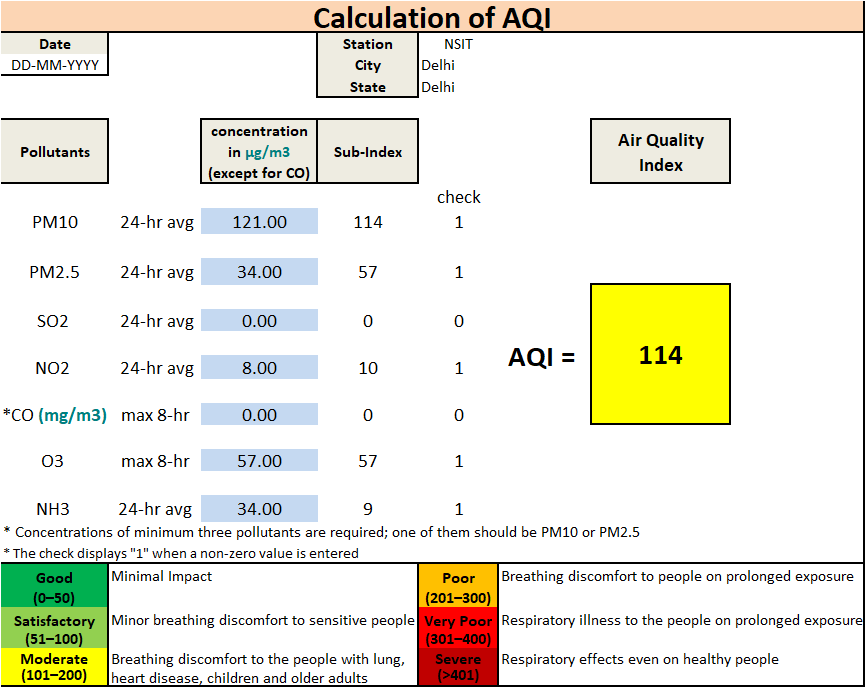

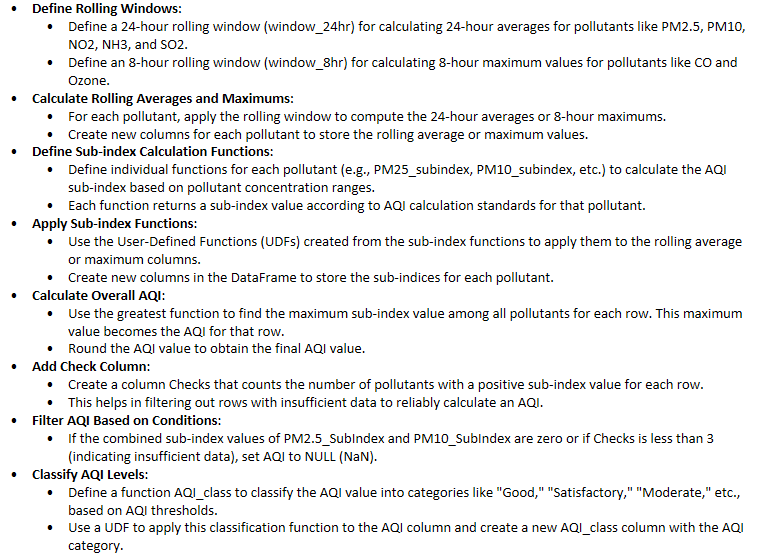

1. Define Rolling Windows
2. Calculate Rolling Averages and Maximums

In [ ]:
# Define window specifications for each operation
window_24hr = Window.partitionBy("City").orderBy("Timestamp").rowsBetween(-23, 0)
window_8hr = Window.partitionBy("City").orderBy("Timestamp").rowsBetween(-7, 0)

# Calculate 24-hour rolling average for each specified column
df_All_cities = df_All_cities \
    .withColumn("PM2p5_24hr_avg", avg("PM2p5").over(window_24hr)) \
    .withColumn("PM10_24hr_avg", avg("PM10").over(window_24hr)) \
    .withColumn("NO2_24hr_avg", avg("NO2").over(window_24hr)) \
    .withColumn("NH3_24hr_avg", avg("NH3").over(window_24hr)) \
    .withColumn("SO2_24hr_avg", avg("SO2").over(window_24hr))

# Calculate 8-hour rolling maximum for each specified column
df_All_cities = df_All_cities \
    .withColumn("CO_8hr_max", max("CO").over(window_8hr)) \
    .withColumn("Ozone_8hr_max", max("Ozone").over(window_8hr))



3.  Define Sub-index Calculation Functions
4. Apply Sub-index Functions

In [ ]:
def PM25_subindex(x):
  if x is not None:
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return None
  else:
    return None

PM25_subindex_udf = udf(PM25_subindex, DoubleType())
df_All_cities = df_All_cities.withColumn("PM2p5_SubIndex", PM25_subindex_udf("PM2p5_24hr_avg"))


def PM10_subindex(x):
  if x is not None:
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return None
  else:
    return None

PM10_subindex_udf = udf(PM10_subindex, DoubleType())
df_All_cities = df_All_cities.withColumn("PM10_SubIndex", PM10_subindex_udf("PM10_24hr_avg"))


def SO2_subindex(x):
  if x is not None:
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return None
  else:
    return None

SO2_subindex_udf = udf(SO2_subindex, DoubleType())
df_All_cities = df_All_cities.withColumn("SO2_SubIndex", SO2_subindex_udf("SO2_24hr_avg"))


def NO2_subindex(x):
  if x is not None:
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return None
  else:
    return None

NO2_subindex_udf = udf(NO2_subindex, DoubleType())
df_All_cities = df_All_cities.withColumn("NO2_SubIndex", NO2_subindex_udf("NO2_24hr_avg"))


def NH3_subindex(x):
  if x is not None:
    if x <= 200:
        return x * 50 / 200
    elif x <= 400:
        return 50 + (x - 200) * 50 / 200
    elif x <= 800:
        return 100 + (x - 400) * 100 / 400
    elif x <= 1200:
        return 200 + (x - 800) * 100 / 400
    elif x <= 1800:
        return 300 + (x - 1200) * 100 / 600
    elif x > 1800:
        return 400 + (x - 1800) * 100 / 600
    else:
        return None
  else:
    return None

NH3_subindex_udf = udf(NH3_subindex, DoubleType())
df_All_cities = df_All_cities.withColumn("NH3_SubIndex", NH3_subindex_udf("NH3_24hr_avg"))


def CO_subindex(x):
  if x is not None:
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return None
  else:
    return None

CO_subindex_udf = udf(CO_subindex, DoubleType())
df_All_cities = df_All_cities.withColumn("CO_SubIndex", CO_subindex_udf("CO_8hr_max"))


def O3_subindex(x):
  if x is not None:
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return None
  else:
    return None

O3_subindex_udf = udf(O3_subindex, DoubleType())
df_All_cities = df_All_cities.withColumn("Ozone_SubIndex", O3_subindex_udf("Ozone_8hr_max"))



5. Add Check Column
6. Calculate Overall AQI
7. Filter AQI Based on Conditions
8. Classify AQI Levels

In [ ]:
df_All_cities = df_All_cities.withColumn(
    "Checks",
    (when(col("PM2p5_SubIndex") > 0, 1).otherwise(0) +
     when(col("PM10_SubIndex") > 0, 1).otherwise(0) +
     when(col("SO2_SubIndex") > 0, 1).otherwise(0) +
     when(col("NO2_SubIndex") > 0, 1).otherwise(0) +
     when(col("NH3_SubIndex") > 0, 1).otherwise(0) +
     when(col("CO_SubIndex") > 0, 1).otherwise(0) +
     when(col("Ozone_SubIndex") > 0, 1).otherwise(0))
)
df_All_cities = df_All_cities.withColumn("AQI" , round(greatest("PM2p5_SubIndex", "PM10_SubIndex", "SO2_SubIndex", "NO2_SubIndex", "NH3_SubIndex", "CO_SubIndex", "Ozone_SubIndex")))

df_All_cities = df_All_cities.withColumn("AQI",when((col("PM2p5_SubIndex") + col("PM10_SubIndex") <= 0) | (col("Checks") < 3), None).otherwise(col("AQI")))

def AQI_class(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return None

AQI_class_udf = udf(AQI_class, StringType())
df_All_cities = df_All_cities.withColumn("AQI_class", AQI_class_udf("AQI"))

In [ ]:
# Show the resulting DataFrame
df_All_cities.filter(col("City") == "Chennai").show(10)

+-------+-------------------+-----------+----+-----------+-----------+-----------+-----+-----------+-----------+------+-------+-------+-----------+-----------+-----------+--------------+------+------+-----------+------------------+-------------+------------------+------------------+------------------+-----------+-------------+------------------+-------------+------------------+------------------+------------------+------------------+--------------+------+-----+------------+
|   City|          Timestamp|      PM2p5|PM10|         NO|        NO2|        NOx|  NH3|        SO2|         CO| Ozone|Benzene|Toluene|Temperature|   Humidity| Wind_Speed|Wind_Direction|TOT-RF|    SR|         BP|    PM2p5_24hr_avg|PM10_24hr_avg|      NO2_24hr_avg|      NH3_24hr_avg|      SO2_24hr_avg| CO_8hr_max|Ozone_8hr_max|    PM2p5_SubIndex|PM10_SubIndex|      SO2_SubIndex|      NO2_SubIndex|      NH3_SubIndex|       CO_SubIndex|Ozone_SubIndex|Checks|  AQI|   AQI_class|
+-------+-------------------+-----------+-

 Replace the NULL values in each numeric column with 0

In [ ]:
numeric_cols

['PM2p5',
 'PM10',
 'NO',
 'NO2',
 'NOx',
 'NH3',
 'SO2',
 'CO',
 'Ozone',
 'Benzene',
 'Toluene',
 'Temperature',
 'Humidity',
 'Wind_Speed',
 'Wind_Direction',
 'TOT-RF',
 'SR',
 'BP']

In [ ]:
df_All_cities = df_All_cities.fillna(0, subset=numeric_cols)

Check the percentage of missing values in all the numeric columns. It should be all 0

In [ ]:
total_rows = df_All_cities.count()
missing_percentage_df = df_All_cities.select([(sum(when(col(c).isNull(), 1).otherwise(0)) / total_rows * 100).alias(c) for c in df_All_cities.columns])
missing_percentage_df.show()

+----+---------+-----+----+---+---+---+---+---+---+-----+-------+-------+-----------+--------+----------+--------------+------+---+---+--------------+------------------+-------------------+------------------+--------------------+----------+--------------------+--------------+------------------+--------------------+-------------------+------------------+-----------+--------------------+------+---+---------+
|City|Timestamp|PM2p5|PM10| NO|NO2|NOx|NH3|SO2| CO|Ozone|Benzene|Toluene|Temperature|Humidity|Wind_Speed|Wind_Direction|TOT-RF| SR| BP|PM2p5_24hr_avg|     PM10_24hr_avg|       NO2_24hr_avg|      NH3_24hr_avg|        SO2_24hr_avg|CO_8hr_max|       Ozone_8hr_max|PM2p5_SubIndex|     PM10_SubIndex|        SO2_SubIndex|       NO2_SubIndex|      NH3_SubIndex|CO_SubIndex|      Ozone_SubIndex|Checks|AQI|AQI_class|
+----+---------+-----+----+---+---+---+---+---+---+-----+-------+-------+-----------+--------+----------+--------------+------+---+---+--------------+------------------+-----------

Add the following features to the dataframe.
1. Vehicular Pollution
2. Industrial Pollution

In [ ]:
df_All_cities = df_All_cities.withColumn("Vehicular_Pollution", col("PM2p5") + col("PM10") + col("NO") + col("NO2") + col("NOx") + col("NH3") + col("CO"))
df_All_cities = df_All_cities.withColumn("Industrial_Pollution", col("SO2") + col("Ozone") + col("Benzene"))

In [ ]:
# Filter for years 2019 to 2022
df_All_cities_2019_2022 = df_All_cities.filter((year("Timestamp") >= 2019) & (year("Timestamp") <= 2022))

# Filter for the year 2023
df_All_cities_2023 = df_All_cities.filter(year("Timestamp") == 2023)

In [ ]:
df_All_cities.printSchema()
df_All_cities_2019_2022.show(5)
df_All_cities_2023.show(5)

root
 |-- City: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- PM2p5: double (nullable = false)
 |-- PM10: double (nullable = false)
 |-- NO: double (nullable = false)
 |-- NO2: double (nullable = false)
 |-- NOx: double (nullable = false)
 |-- NH3: double (nullable = false)
 |-- SO2: double (nullable = false)
 |-- CO: double (nullable = false)
 |-- Ozone: double (nullable = false)
 |-- Benzene: double (nullable = false)
 |-- Toluene: double (nullable = false)
 |-- Temperature: double (nullable = false)
 |-- Humidity: double (nullable = false)
 |-- Wind_Speed: double (nullable = false)
 |-- Wind_Direction: double (nullable = false)
 |-- TOT-RF: double (nullable = false)
 |-- SR: double (nullable = false)
 |-- BP: double (nullable = false)
 |-- PM2p5_24hr_avg: double (nullable = true)
 |-- PM10_24hr_avg: double (nullable = true)
 |-- NO2_24hr_avg: double (nullable = true)
 |-- NH3_24hr_avg: double (nullable = true)
 |-- SO2_24hr_avg: double (nullable = true)
 

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GeneralizedLinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import numpy as np
import time

# Vectorize the feature columns
assembler = VectorAssembler(inputCols=['PM2p5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'Ozone'], outputCol='features')

# Split the data into training and validate sets (80-20)
train_data, validate_data = df_All_cities_2019_2022.randomSplit([0.8, 0.2], seed=1234)

# Use 2023 as the test data (unseen by model)
test_data = df_All_cities_2023


# Linear Regression (standard)
lr = LinearRegression(featuresCol='features', labelCol='AQI')

# Lasso Regression (L1 regularization)
lasso = GeneralizedLinearRegression(family="gaussian", link="identity",
                                    featuresCol='features', labelCol='AQI',
                                    regParam=0.1)  # ElasticNetParam=1.0 for Lasso

# Ridge Regression (L2 regularization)
ridge = GeneralizedLinearRegression(family="gaussian", link="identity",
                                    featuresCol='features', labelCol='AQI',
                                    regParam=0.1)  # ElasticNetParam=0.0 for Ridge

# Decision Tree Regressor
dt = DecisionTreeRegressor(featuresCol='features', labelCol='AQI')

# Random Forest Regressor
rf = RandomForestRegressor(featuresCol='features', labelCol='AQI')

# Define a function for model evaluation
def validate_n_test_model(model, train_data, validate_data, test_data):

    t0 = time.time()
    # Create a pipeline with feature vectorization and the model
    pipeline = Pipeline(stages=[assembler, model])

    # Fit the model on the training data
    model_fitted = pipeline.fit(train_data)

    train_time = time.time() - t0
    t1 = time.time()

    # Make predictions on the validate data
    predictions = model_fitted.transform(validate_data)

    # Make predictions on the test data
    test_predictions = model_fitted.transform(test_data)
    prediction_time = time.time() - t1
    t1 = time.time()

    # Evaluate the model performance
    evaluator = RegressionEvaluator(labelCol="AQI", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)

    r2_evaluator = RegressionEvaluator(labelCol="AQI", predictionCol="prediction", metricName="r2")
    r2 = r2_evaluator.evaluate(predictions)
    test_r2 = r2_evaluator.evaluate(test_predictions)

    evaluation_time = time.time() - t1

    return rmse, r2, test_r2, train_time, prediction_time, evaluation_time

# Evaluate each model and compare performance

models = {
    "Linear Regression": lr,
    "Lasso Regression": lasso,
    "Ridge Regression": ridge,
    "Decision Tree Regressor": dt,
    "Random Forest Regressor": rf
}

# Store performance results
model_results = {}

for model_name, model in models.items():
    rmse, r2, test_r2, train_time, prediction_time, evaluation_time = validate_n_test_model(model, train_data, validate_data, test_data)
    total_time = train_time + prediction_time + evaluation_time
    model_results[model_name] = {"RMSE": rmse, "R2": r2, "Test_R2": test_r2, "Train_time": train_time, "Prediction_time": prediction_time, "Evaluation_time": evaluation_time, "Total_time": total_time}

# Comparison of the models
print("Model Comparison (RMSE, R2 & Test_R2):")
for model_name, results in model_results.items():
    print(f"{model_name} -> RMSE: {results['RMSE']}, R2: {results['R2']}, Test_R2: {results['Test_R2']}")


Model Comparison (RMSE, R2 & Test_R2):
Linear Regression -> RMSE: 39.49495651985374, R2: 0.792673683851798, Test_R2: 0.8134772034567387
Lasso Regression -> RMSE: 39.49464990622338, R2: 0.7926769029376414, Test_R2: 0.8134341540994758
Ridge Regression -> RMSE: 39.49464990622338, R2: 0.7926769029376414, Test_R2: 0.8134341540994758
Decision Tree Regressor -> RMSE: 38.126043426922344, R2: 0.8067966611650182, Test_R2: 0.8157234863831218
Random Forest Regressor -> RMSE: 37.110799228801305, R2: 0.8169491431880034, Test_R2: 0.8247762373907946


In [ ]:
# Hyperparameter Tuning using CrossValidator for Random Forest

rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [2, 7]) \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .build()

rf_evaluator = RegressionEvaluator(labelCol="AQI", predictionCol="prediction", metricName="rmse")

rf_cv = CrossValidator(estimator=rf,
                       estimatorParamMaps=rf_param_grid,
                       evaluator=rf_evaluator,
                       numFolds=3)

t0 = time.time()
pipeline = Pipeline(stages=[assembler, rf_cv])
rf_model = pipeline.fit(train_data)
train_time = time.time() - t0

t1 = time.time()
# Evaluate the model performance on validate data
predictions = rf_model.transform(validate_data)
# Evaluate the model performance on test data
test_predictions = rf_model.transform(test_data)

prediction_time = time.time() - t1

t1 = time.time()
# Evaluate the predictions using RMSE and R2
evaluator = RegressionEvaluator(labelCol="AQI", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

r2_evaluator = RegressionEvaluator(labelCol="AQI", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)

r2_evaluator = RegressionEvaluator(labelCol="AQI", predictionCol="prediction", metricName="r2")
test_r2 = r2_evaluator.evaluate(test_predictions)
evaluation_time = time.time() - t1

total_time = train_time + prediction_time + evaluation_time

model_results["Random Forest with RGSCV"] = {"RMSE": rmse, "R2": r2, "Test_R2": test_r2, "Train_time": train_time, "Prediction_time": prediction_time, "Evaluation_time": evaluation_time, "Total_time": total_time}

# Performance metrics
print(f"Random Forest Model Performance:")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")
print(f"Test_R2: {test_r2}")

# Extract best model parameters
best_model = rf_model.stages[1].bestModel
print(f"Best Model Parameters:")
print(f"maxDepth: {best_model._java_obj.getMaxDepth()}")
print(f"numTrees: {best_model._java_obj.getNumTrees()}")
print(f"maxBins: {best_model._java_obj.getMaxBins()}")

Random Forest Model Performance:
RMSE: 34.71239160326762
R2: 0.8398451023895068
Test_R2: 0.8388111770109559
Best Model Parameters:
maxDepth: 7
numTrees: 20
maxBins: 64


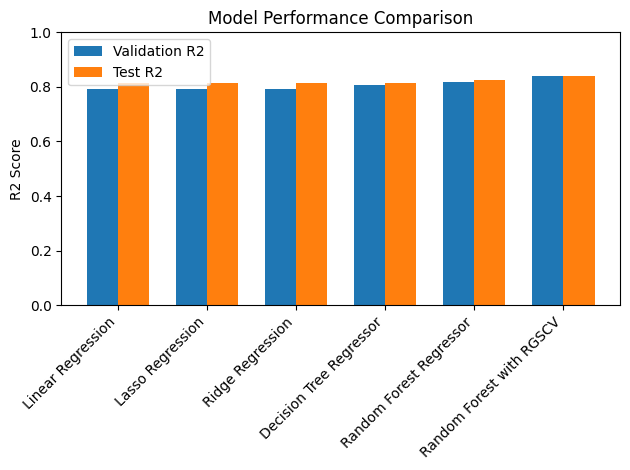

In [ ]:
import matplotlib.pyplot as plt

model_names = list(model_results.keys())
r2_scores = [model_results[model]['R2'] for model in model_names]
test_r2_scores = [model_results[model]['Test_R2'] for model in model_names]

x = np.arange(len(model_names))
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, r2_scores, width, label='Validation R2')
rects2 = ax.bar(x + width/2, test_r2_scores, width, label='Test R2')

ax.set_ylim(0, 1)
ax.set_ylabel('R2 Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha="right")
ax.legend()

fig.tight_layout()
plt.show()

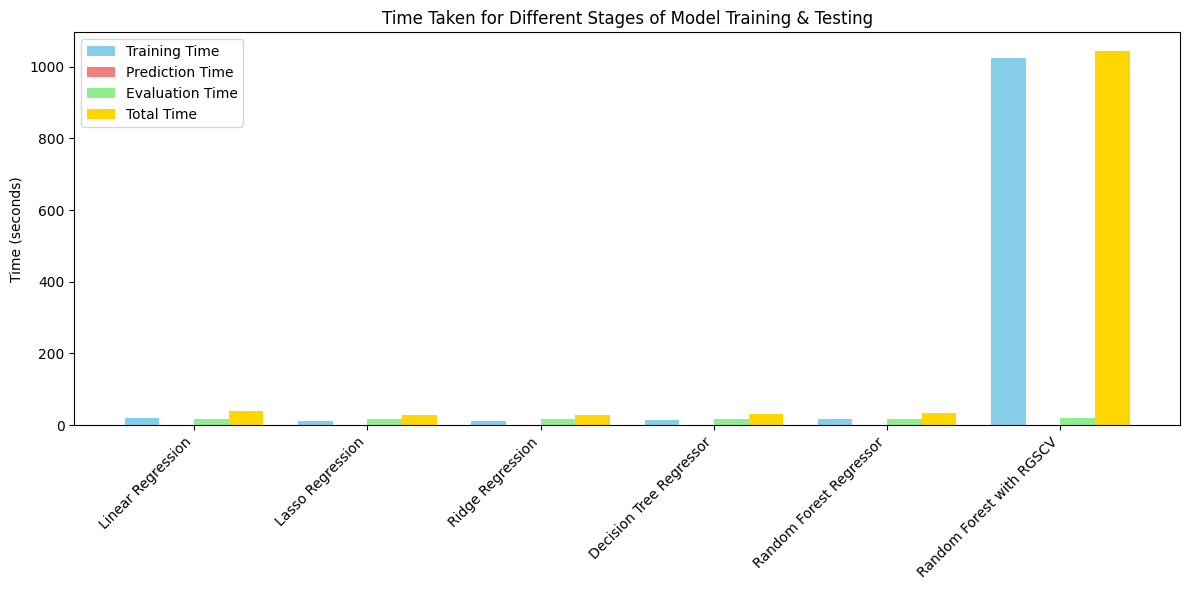

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model_names = list(model_results.keys())
train_times = [model_results[model]['Train_time'] for model in model_names]
prediction_times = [model_results[model]['Prediction_time'] for model in model_names]
evaluation_times = [model_results[model]['Evaluation_time'] for model in model_names]
total_times = [model_results[model]['Total_time'] for model in model_names]

x = np.arange(len(model_names))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - 1.5*width, train_times, width, label='Training Time', color='skyblue')
rects2 = ax.bar(x - 0.5*width, prediction_times, width, label='Prediction Time', color='lightcoral')
rects3 = ax.bar(x + 0.5*width, evaluation_times, width, label='Evaluation Time', color='lightgreen')
rects4 = ax.bar(x + 1.5*width, total_times, width, label='Total Time', color='gold')


ax.set_ylabel('Time (seconds)')
ax.set_title('Time Taken for Different Stages of Model Training & Testing')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha="right")
ax.legend()

fig.tight_layout()
plt.show()